In [348]:
#| default_exp gaussian_convolution
from nbdev.showdoc import *
import numpy as np
from diffusion_curvature.core import plot_3d
import scipy
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Curvature via the Convoluted Properties of the Euclidean Gaussian

A gaussian, convolved with itself, is another gaussian with twice the variance.
A euclidean diffusion, convolved with itself, should be a euclidean diffusion with the same center diffused for twice the time.
This notebook computes this convolution using the graph fourier transform, leveraging the principle that convolution in the space domain is multiplication in the frequency domain. Hence, we need only to derive the frequencies of a diffusion (with the graph fourier transform), square them, perform the inverse graph fourier transform, and compare the resulting distribution with a diffusion over twice the time. By the properties of the euclidean gaussian, we expect these to be equal in spaces of flat curvature.

 A further question to be explored by this notebook: can this same procedure differentiate between positive and negative curvature?

## Computing the Eigenvectors of the Laplacian
(Following [Sumry2021_DiffusionTopology_Writeup](x-devonthink-item://7E1EE13E-36F7-4D3B-9514-5066C2147333))


In [349]:
from diffusion_curvature.gaussian_invariance import compute_anisotropic_affinities_from_graph

In [350]:
def get_laplacian_evecs(A, normalized = True):
    """Returns the eigenvectors of the graph laplacian, in the rows"""
    D = np.diag(np.sum(A,axis=1))
    D_n = np.diag(1/np.sum(A,axis=1))
    D_noh = np.diag(np.sum(A,axis=1)**(-0.5))
    if not normalized:
        L = np.eye(len(A)) - D_n @ A
    else:
        L = D_noh @ (D - A) @ D_noh
    # compute eigenvectors of L; returned in columns
    # sort the eigenvectors by eigenval
    e, v = np.linalg.eigh(L)
    e_sorted_idxs = np.argsort(e) # sorts from lowest to highest
    v_rows = v.T
    v_rows_sorted = v_rows[e_sorted_idxs]
    e_sorted = e[e_sorted_idxs]
    return e_sorted[1:], v_rows_sorted[1:]

def graph_fourier_transform(
        psi:np.ndarray, # the matrix of eigenvectors of the graph laplacian, in the rows (n x n)
        signal:np.ndarray, # the signal to transform to the frequency domain (n x 1)
        alpha=1):
    signal_in_freq_domain = psi @ signal
    return signal_in_freq_domain

def inverse_graph_fourier_transform(psi, freqs):
    return psi.T @ freqs

def convolve_signal_with_itself(psi, signal):
    freqs = graph_fourier_transform(psi, signal)
    return inverse_graph_fourier_transform(psi, freqs**2)

# Testing

## On the Plane

In [351]:
from diffusion_curvature.datasets import sphere
from diffusion_curvature.core import diffusion_matrix, gaussian_kernel
def plot_diffusion_as_3d(points,signal):
    combined_points = np.hstack([points,signal[:,None]])
    plot_3d(combined_points,signal,lim=1)

X = np.random.rand(4000,2)*2 - 1
X = np.vstack([np.zeros(2),X])
A = gaussian_kernel(X,kernel_type="adaptive anisotropic")
# binarize the adjacency matrix; this is necessary to prevent the eigenvalues from being really big.
# get mean biggest value
# A = (A > np.sort(A.flatten())[::-1][len(A)*30]).astype(int)
e, v = get_laplacian_evecs(A)

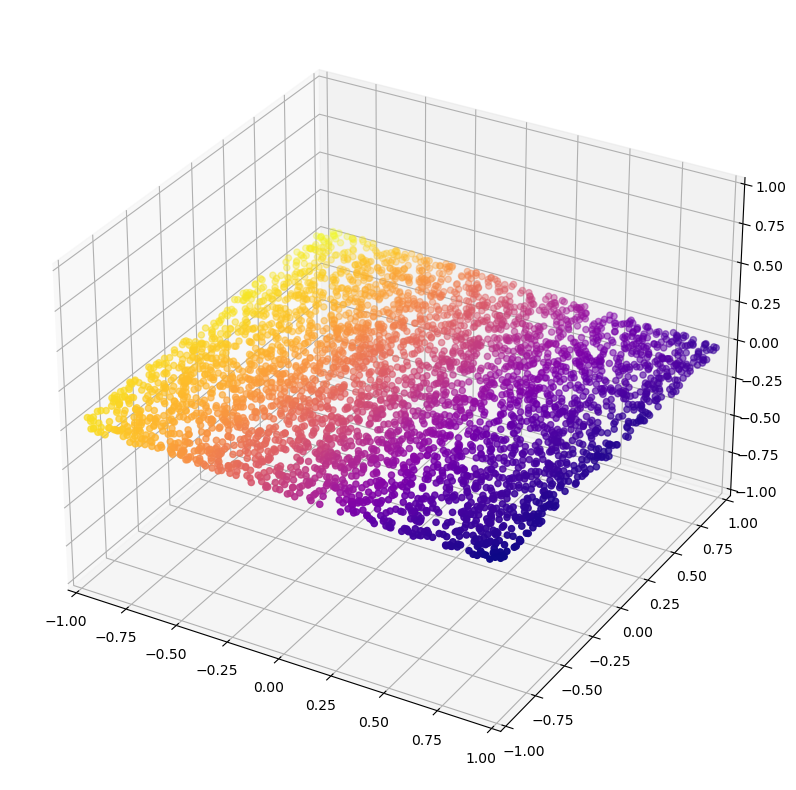

In [352]:
plot_diffusion_as_3d(X,v[1])

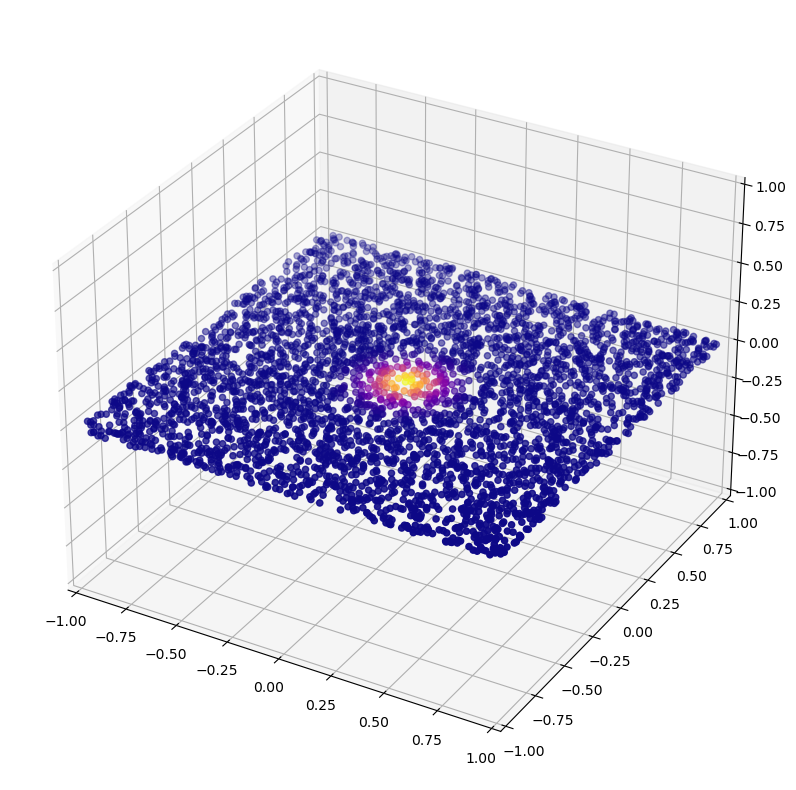

In [353]:
P = diffusion_matrix(X, kernel_type="anisotropic", affinity_matrix_only=False, sigma=0.1)
P_2 = P @ P
P_4 = P_2 @ P_2
diffused_signal_1 = P[0]
diffused_signal_2 = P_2[0]
diffused_signal_4 = P_4[0]
plot_diffusion_as_3d(X, diffused_signal_1)

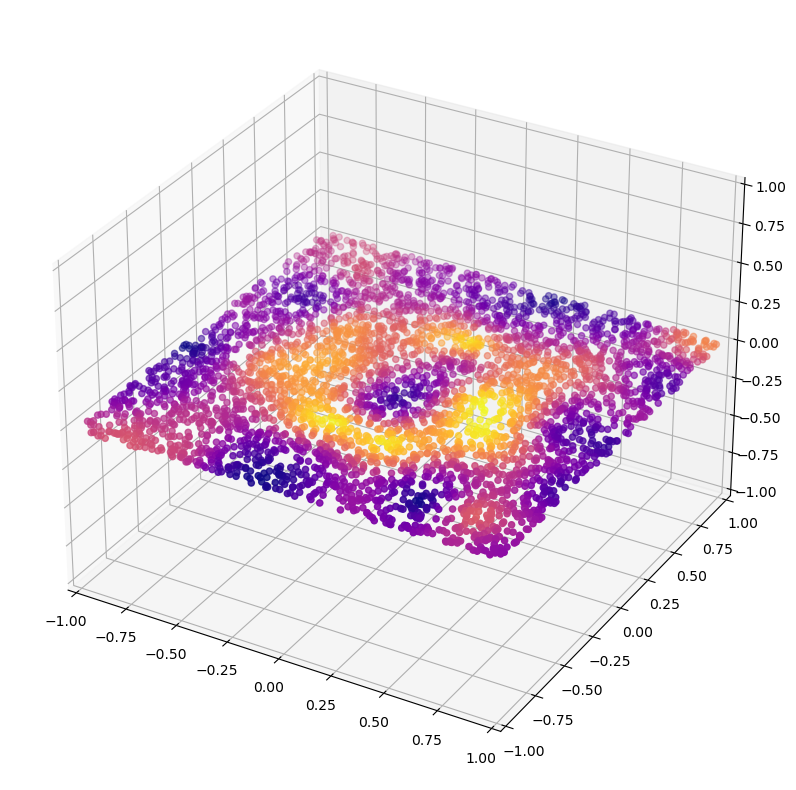

In [354]:
convolved_diffusion_1 = convolve_signal_with_itself(v, diffused_signal_1)
plot_diffusion_as_3d(X, convolved_diffusion_1)

In [355]:
freqs = graph_fourier_transform(v, diffused_signal_1)
freqs

array([-3.93105445e-05, -1.49250862e-04,  3.96919795e-04, ...,
       -1.01817393e-08, -9.57194222e-09,  1.81909000e-09])

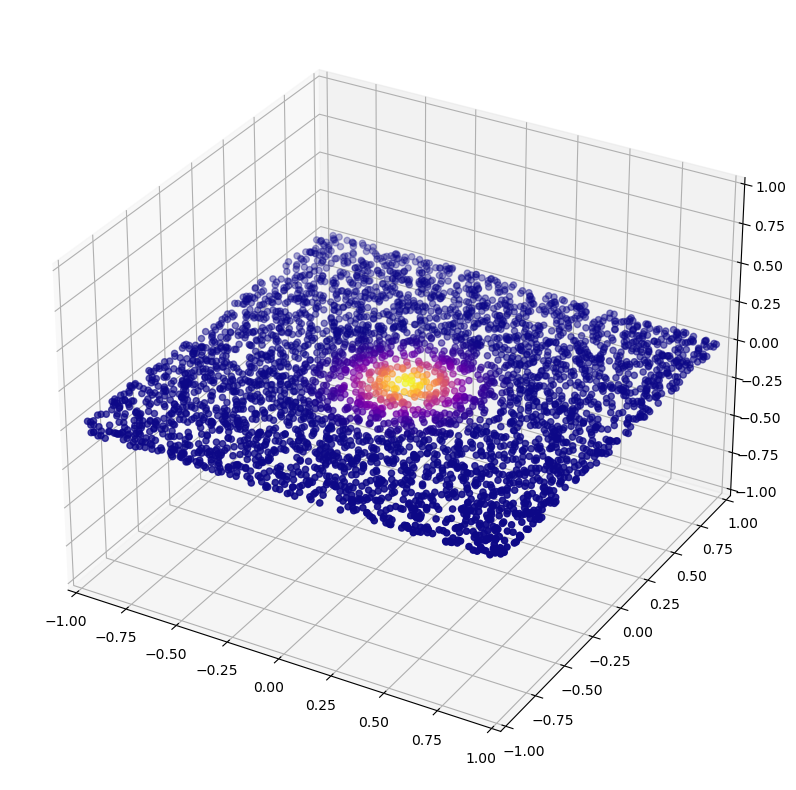

In [356]:
plot_diffusion_as_3d(X,diffused_signal_2)

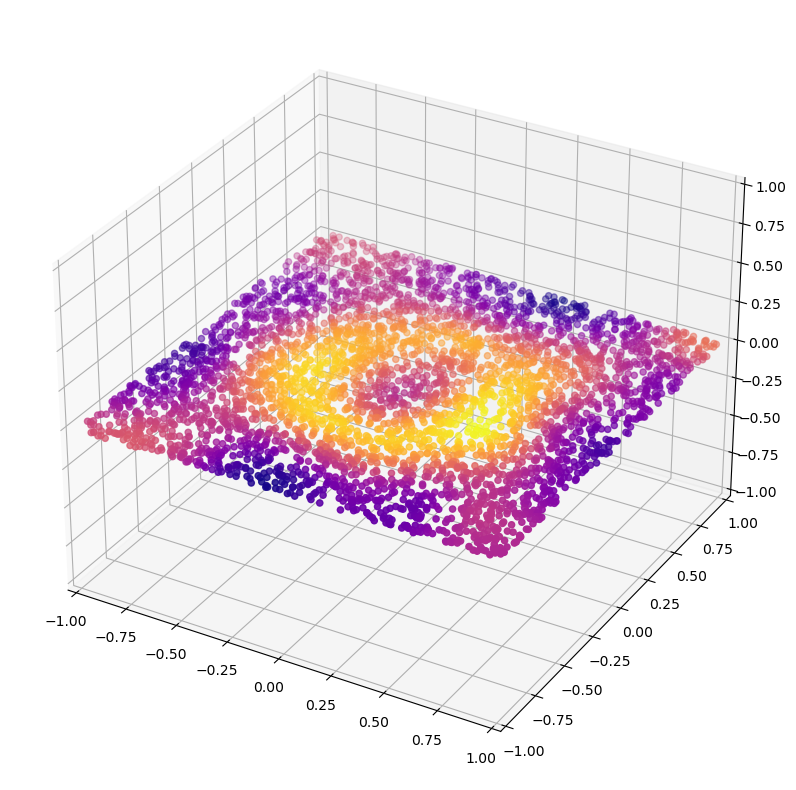

In [357]:
convolved_diffusion_2 = convolve_signal_with_itself(v, diffused_signal_2)
plot_diffusion_as_3d(X, convolved_diffusion_2)

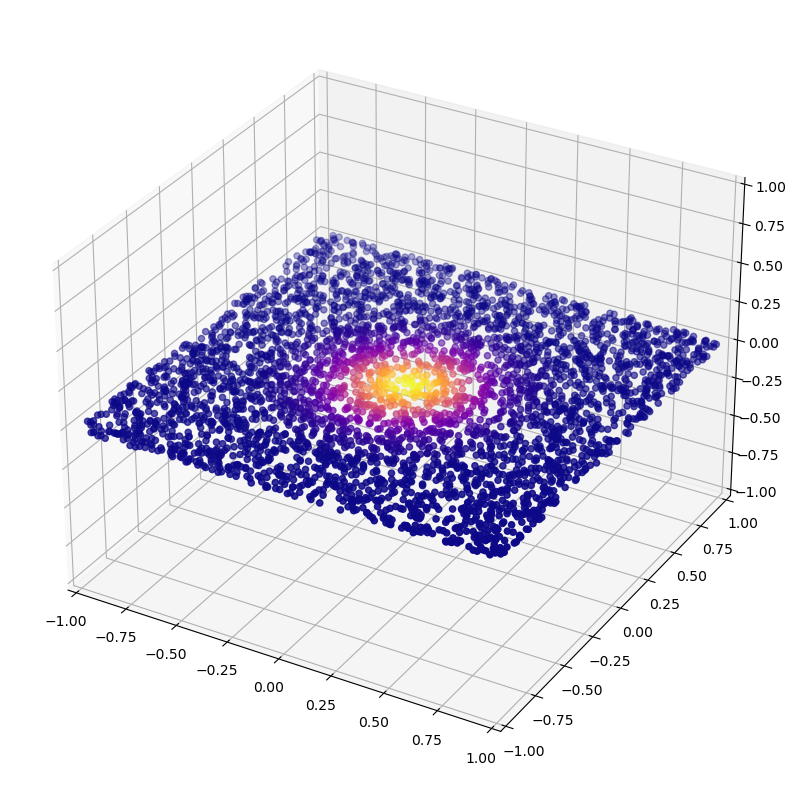

In [358]:
plot_diffusion_as_3d(X,diffused_signal_4)

## On The Sphere

In [359]:
from diffusion_curvature.datasets import sphere
from diffusion_curvature.core import diffusion_matrix
X, ks_real = sphere(2000)
A = gaussian_kernel(X,kernel_type="adaptive anisotropic")
# binarize the adjacency matrix; this is necessary to prevent the eigenvalues from being really big.
# get mean biggest value
A = (A > np.sort(A.flatten())[::-1][len(A)*30]).astype(int)
e, v = get_laplacian_evecs(A)

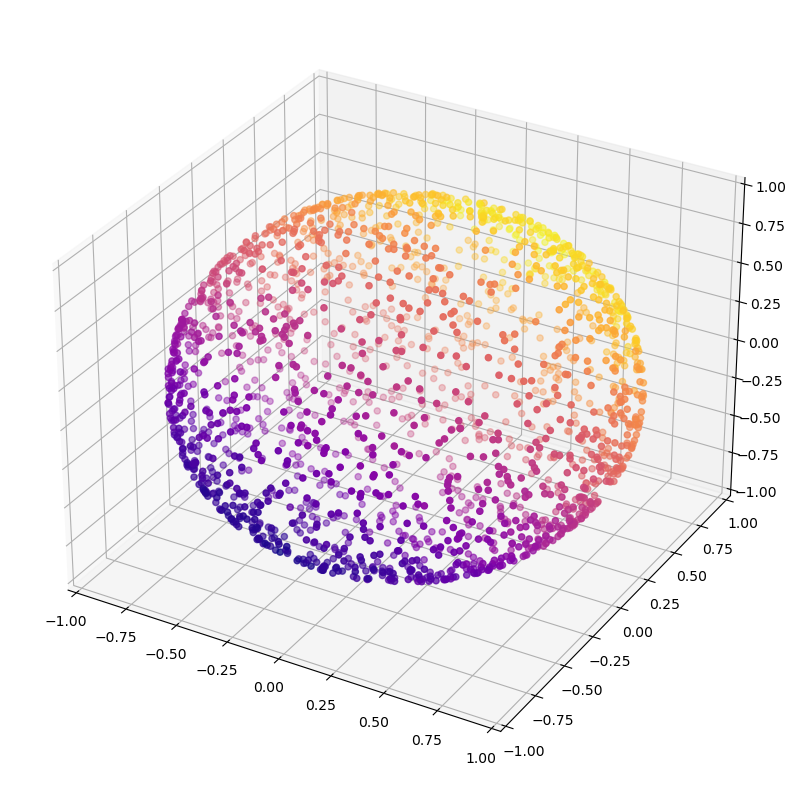

In [360]:
plot_3d(X,v[1])

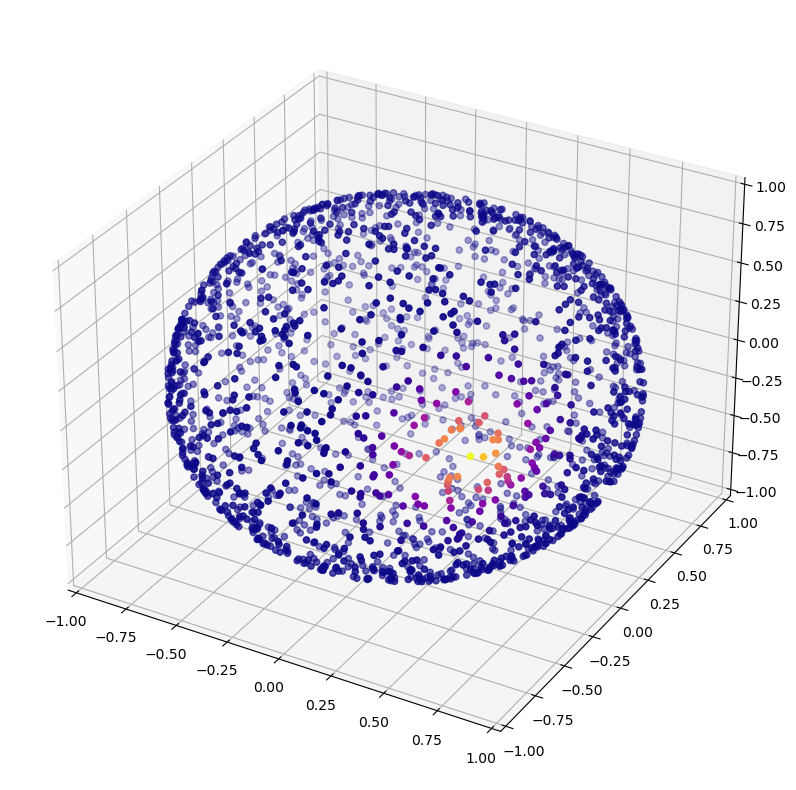

In [361]:
P = diffusion_matrix(X,kernel_type="adaptive anisotropic",affinity_matrix_only=False)
P_2 = P @ P
P_4 = P_2 @ P_2
diffused_signal_1 = P[0]
diffused_signal_2 = P_2[0]
diffused_signal_4 = P_4[0]
plot_3d(X,diffused_signal_1)

In [362]:
freqs_of_diffusion = graph_fourier_transform(v, diffused_signal_1)

In [363]:
freqs_of_diffusion

array([ 3.06758091e-02, -7.58301643e-03,  1.73319538e-02, ...,
        4.08056488e-05,  2.23715080e-06,  8.18684580e-05])

In [364]:
decoded_diffused_signal_1 = inverse_graph_fourier_transform(v, freqs_of_diffusion)
np.allclose(decoded_diffused_signal_1,diffused_signal_1)

False

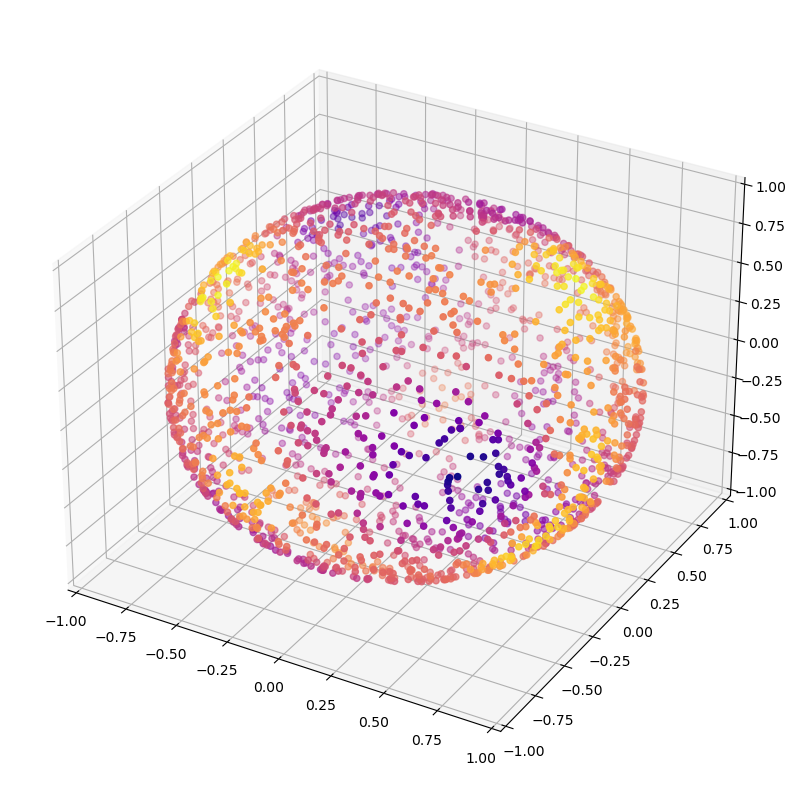

In [365]:
convolved_diffusion_1 = convolve_signal_with_itself(v, diffused_signal_1)
plot_3d(X,convolved_diffusion_1)

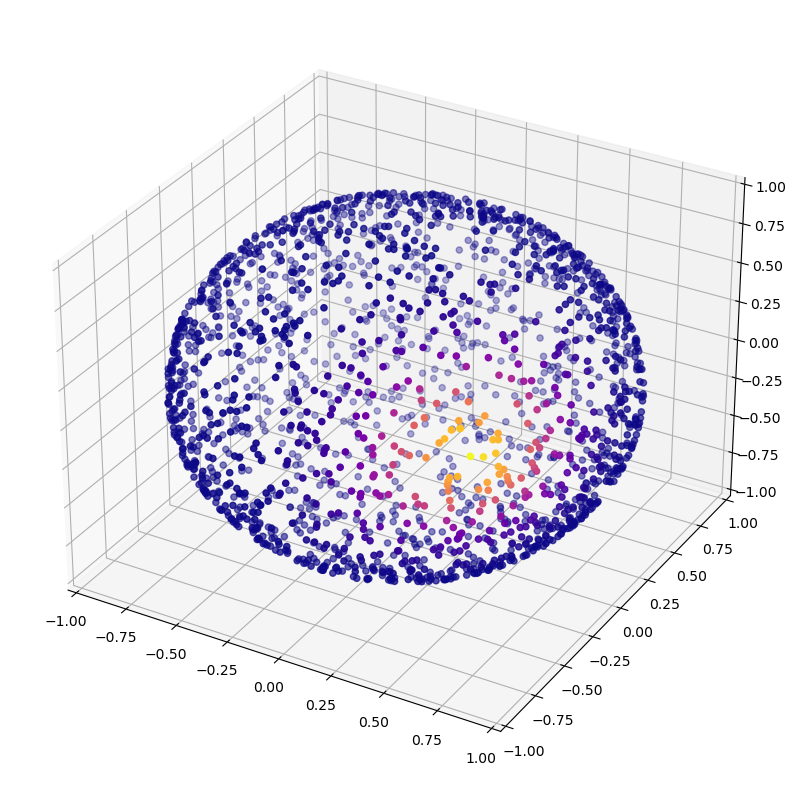

In [366]:
plot_3d(X, diffused_signal_2)